## AI project/ part 2

### Importing the libraries

In [ ]:
import os
from os.path import exists
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from shutil import copyfile
import torchvision
from PIL import Image
import io
import random
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
import pandas as pd
from torchvision.transforms import ToTensor, Lambda
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from skorch import NeuralNetClassifier
import sklearn
#from pytorchtools import EarlyStopping

 Here, we just set our working directory to the path including our dataset.

In [ ]:
os.chdir(r"C:\Concordia_Program\AI\project_part2");
path = r"C:\Concordia_Program\AI\project_part2"

### Defining a custom dataset for our images

In [ ]:
class CustomImageDataset():
    def __init__(self, annotations_file, img_dir,
            transform=torchvision.transforms.Compose([
                transforms.ToPILImage(),
                transforms.Grayscale(num_output_channels=3),
                transforms.ToTensor(),
                #Resizing all of the imagesin the dataset to (240,240)
                transforms.Resize((240,240)),
                #Normalization using the mean and variance over the whole dataset
                transforms.Normalize((0.5352, 0.5352, 0.5352),(0.3009, 0.3009, 0.3009))]),
                 #Lambda function is used for turning the integer into a tensor
            target_transform=Lambda(lambda y: torch.zeros(5, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))):
        self.img_labels = pd.read_csv(annotations_file)   #Dataaset labels
        self.img_dir = img_dir      #Dataset image path     
        self.transform = transform   
        self.target_transform = target_transform
        

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        if(os.path.exists(img_path)):
            image = read_image(img_path)
            label = torch.tensor(int(self.img_labels.iloc[idx, 1]))
            if self.transform:
                image = self.transform(image)
            image.shape
            return image, label

### Augmentation technique for increasing the size of dataset
In this part, we selected a number of images in all of the classes except for the cloth mask class and we increased their number by using augmentation technique. We rotated theimages by 180 degrees which resulted in producing new data samples.

In [ ]:
class AugmentedDataset():
    def __init__(self, annotations_file, img_dir,
            transform=torchvision.transforms.Compose([
                transforms.ToPILImage(),
                transforms.Grayscale(num_output_channels=3),
                transforms.ToTensor(),
                transforms.Resize((240,240)),
                transforms.RandomRotation(degrees=180),#Augmentation
                transforms.RandomHorizontalFlip(p=1),#Augmentation
                #Normalization for all dataset using mean and varinace
                transforms.Normalize((0.5352, 0.5352, 0.5352),(0.3009, 0.3009, 0.3009))]),
            target_transform=Lambda(lambda y: torch.zeros(5, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))):
        self.img_labels = pd.read_csv(annotations_file) #Dataaset labels
        self.img_dir = img_dir   #Dataset image path
        self.transform = transform
        self.target_transform = target_transform
        

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        if(os.path.exists(img_path)):
            image = read_image(img_path)
            label = torch.tensor(int(self.img_labels.iloc[idx, 1]))
            if self.transform:
                image = self.transform(image)
            image.shape
            return image, label
        
        

### Spiliting defined dataset to train and test sets

In [ ]:
validation_split = .2
shuffle_dataset = True
random_seed= 32   #Preventing from random events in each run
dataset1=CustomImageDataset(annotations_file=r'C:\Concordia_Program\AI\project_part2\Data280.csv', img_dir=r'C:\Concordia_Program\AI\project_part2\Data280')
dataset2=AugmentedDataset(annotations_file=r'C:\Concordia_Program\AI\project_part2\augmentedlabels.csv', img_dir=r'C:\Concordia_Program\AI\project_part2\augmented')
dataset = ConcatDataset([dataset1, dataset2]) #Combining our initial dataset with the augmented one
m = len(dataset)
print(m)
# Spilitting dataset to trainset and testset randomly (80 percent train and 20 percent test data)
Dataset, testset = random_split(dataset, [int(np.floor(m - m * 0)), int(np.ceil(m * 0))]) #Using whole dataset for 10-fold cross validation
print(Dataset)

y = np.array([y for x, y in iter(Dataset)])

X = np.array([x.numpy() for x, y in iter(Dataset)])
print(X.shape) 
print(y.shape)

2758
(2758, 3, 240, 240)
(2758,)


### Defining a function for getting mean and variance 

This function helps to do the normalization over the dataset.

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        channels_sum += torch.mean(data, dim=[0,2,3]) #Computing the mean
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5 #Computing the standard deviation

    return mean, std



In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=4, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 4
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        save_path = r"C:\Concordia_Program\AI\project_phase1"
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = save_path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
                    
        torch.save(model.state_dict(), os.path.join(self.path,"ourmodel_part2.pth"))
        self.val_loss_min = val_loss

### Defining the CNN network
Here, we define our CNN network with 5 convolutional layers.

In [ ]:
classes = ('Cloth mask', 'N95 and FFP2', 'N95 and FFP2 with valve', 'Surgical mask','No mask') # 5 classes
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), #First layer
            nn.BatchNorm2d(32),                 #Batch normalization
            nn.LeakyReLU(inplace=True),         #Leaky ReLU activation function
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), #Second layer
            nn.BatchNorm2d(32),                #Batch normalization
            nn.LeakyReLU(inplace=True),        #Leaky ReLU activation function
            nn.MaxPool2d(kernel_size=2, stride=2),     #Max pooling
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), #Third layer
            nn.BatchNorm2d(64),              #Batch normalization
            nn.LeakyReLU(inplace=True),      #Leaky ReLU activation function
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), #Fourth layer
            nn.BatchNorm2d(64),             #Batch normalization
            nn.LeakyReLU(inplace=True),     #Leaky ReLU activation function
            nn.MaxPool2d(kernel_size=2, stride=2),    #Max pooling
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), #Fifth layer
            nn.BatchNorm2d(64),            #Batch normalization
            nn.LeakyReLU(inplace=True),    #Leaky ReLU activation function
            nn.MaxPool2d(kernel_size=2, stride=2)    #Max pooling
          )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),   #0.1 dropout rate
            nn.Linear(57600, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 5) #outputs = number of classes
          )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        #fc layer
        x = self.fc_layer(x)
        
        return x


### 10 fold cross validation
In this part, we are using 5 fold cross validation for improving the training process of our model. In each step, train set is divided to 80 percent and 20 percent for training and evaluation respectively.

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
Starting testing
Accuracy for fold 0: 40 %
--------------------------------
[ 1/20] train_loss: 5.02474 valid_loss: 1.45567
Validation loss decreased (inf --> 1.455669).  Saving model ...
Starting epoch 2
Starting testing
Accuracy for fold 0: 38 %
--------------------------------
[ 2/20] train_loss: 1.36374 valid_loss: 1.45599
EarlyStopping counter: 1 out of 4
Starting epoch 3
Starting testing
Accuracy for fold 0: 46 %
--------------------------------
[ 3/20] train_loss: 1.26778 valid_loss: 1.33545
Validation loss decreased (1.455669 --> 1.335450).  Saving model ...
Starting epoch 4
Starting testing
Accuracy for fold 0: 47 %
--------------------------------
[ 4/20] train_loss: 1.21714 valid_loss: 1.50072
EarlyStopping counter: 1 out of 4
Starting epoch 5
Starting testing
Accuracy for fold 0: 51 %
--------------------------------
[ 5/20] train_loss: 1.11370 valid_loss: 1.27739
Validation loss decre

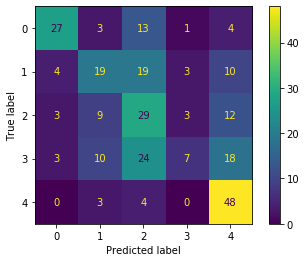

C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1270: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Precision : 47.101 %
Recall : 47.101 %
F1_score : 47.101 %
FOLD 1
--------------------------------
Starting epoch 1
Starting testing
Accuracy for fold 1: 39 %
--------------------------------
[ 1/20] train_loss: 4.51808 valid_loss: 1.43768
Validation loss decreased (inf --> 1.437677).  Saving model ...
Starting epoch 2
Starting testing
Accuracy for fold 1: 43 %
--------------------------------
[ 2/20] train_loss: 1.34911 valid_loss: 1.37827
Validation loss decreased (1.437677 --> 1.378268).  Saving model ...
Starting epoch 3
Starting testing
Accuracy for fold 1: 42 %
--------------------------------
[ 3/20] train_loss: 1.29707 valid_loss: 1.35957
Validation loss decreased (1.378268 --> 1.359574).  Saving model ...
Starting epoch 4
Starting testing
Accuracy for fold 1: 45 %
--------------------------------
[ 4/20] train_loss: 1.20764 valid_loss: 1.31932
Validation loss decreased (1.359574 --> 1.319321).  Saving model ...
Starting epoch 5
Starting testing
Accuracy for fold 1: 46 %
------

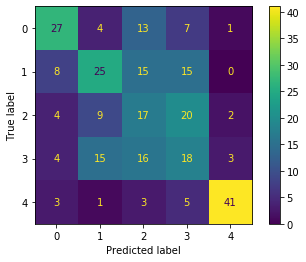

C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1270: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Precision : 46.377 %
Recall : 46.377 %
F1_score : 46.377 %
FOLD 2
--------------------------------
Starting epoch 1
Starting testing
Accuracy for fold 2: 33 %
--------------------------------
[ 1/20] train_loss: 3.77463 valid_loss: 1.53241
Validation loss decreased (inf --> 1.532405).  Saving model ...
Starting epoch 2
Starting testing
Accuracy for fold 2: 41 %
--------------------------------
[ 2/20] train_loss: 1.36897 valid_loss: 1.33395
Validation loss decreased (1.532405 --> 1.333946).  Saving model ...
Starting epoch 3
Starting testing
Accuracy for fold 2: 51 %
--------------------------------
[ 3/20] train_loss: 1.28333 valid_loss: 1.22711
Validation loss decreased (1.333946 --> 1.227110).  Saving model ...
Starting epoch 4
Starting testing
Accuracy for fold 2: 47 %
--------------------------------
[ 4/20] train_loss: 1.22999 valid_loss: 1.30846
EarlyStopping counter: 1 out of 4
Starting epoch 5
Starting testing
Accuracy for fold 2: 50 %
--------------------------------
[ 5/20] 

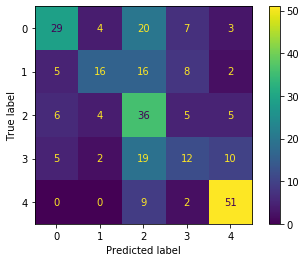

C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1270: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Precision : 52.174 %
Recall : 52.174 %
F1_score : 52.174 %
FOLD 3
--------------------------------
Starting epoch 1
Starting testing
Accuracy for fold 3: 41 %
--------------------------------
[ 1/20] train_loss: 3.52810 valid_loss: 1.36523
Validation loss decreased (inf --> 1.365226).  Saving model ...
Starting epoch 2
Starting testing
Accuracy for fold 3: 47 %
--------------------------------
[ 2/20] train_loss: 1.34064 valid_loss: 1.33405
Validation loss decreased (1.365226 --> 1.334051).  Saving model ...
Starting epoch 3
Starting testing
Accuracy for fold 3: 46 %
--------------------------------
[ 3/20] train_loss: 1.26358 valid_loss: 1.31684
Validation loss decreased (1.334051 --> 1.316840).  Saving model ...
Starting epoch 4
Starting testing
Accuracy for fold 3: 47 %
--------------------------------
[ 4/20] train_loss: 1.19195 valid_loss: 1.29723
Validation loss decreased (1.316840 --> 1.297230).  Saving model ...
Starting epoch 5
Starting testing
Accuracy for fold 3: 50 %
------

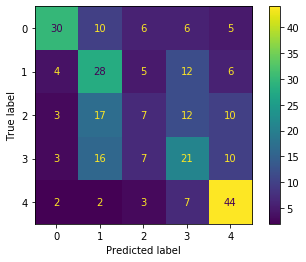

C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1270: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Precision : 47.101 %
Recall : 47.101 %
F1_score : 47.101 %
FOLD 4
--------------------------------
Starting epoch 1
Starting testing
Accuracy for fold 4: 40 %
--------------------------------
[ 1/20] train_loss: 3.54701 valid_loss: 1.41946
Validation loss decreased (inf --> 1.419465).  Saving model ...
Starting epoch 2
Starting testing
Accuracy for fold 4: 43 %
--------------------------------
[ 2/20] train_loss: 1.37589 valid_loss: 1.34096
Validation loss decreased (1.419465 --> 1.340962).  Saving model ...
Starting epoch 3
Starting testing
Accuracy for fold 4: 44 %
--------------------------------
[ 3/20] train_loss: 1.27064 valid_loss: 1.26561
Validation loss decreased (1.340962 --> 1.265608).  Saving model ...
Starting epoch 4
Starting testing
Accuracy for fold 4: 46 %
--------------------------------
[ 4/20] train_loss: 1.22777 valid_loss: 1.22877
Validation loss decreased (1.265608 --> 1.228769).  Saving model ...
Starting epoch 5
Starting testing
Accuracy for fold 4: 50 %
------

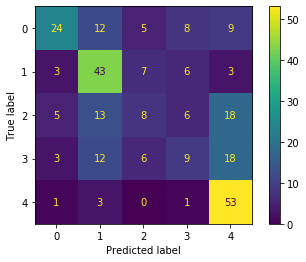

C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1270: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Precision : 49.638 %
Recall : 49.638 %
F1_score : 49.638 %
FOLD 5
--------------------------------
Starting epoch 1
Starting testing
Accuracy for fold 5: 41 %
--------------------------------
[ 1/20] train_loss: 4.17823 valid_loss: 1.43668
Validation loss decreased (inf --> 1.436676).  Saving model ...
Starting epoch 2
Starting testing
Accuracy for fold 5: 38 %
--------------------------------
[ 2/20] train_loss: 1.33650 valid_loss: 1.44053
EarlyStopping counter: 1 out of 4
Starting epoch 3
Starting testing
Accuracy for fold 5: 46 %
--------------------------------
[ 3/20] train_loss: 1.24988 valid_loss: 1.33845
Validation loss decreased (1.436676 --> 1.338446).  Saving model ...
Starting epoch 4
Starting testing
Accuracy for fold 5: 47 %
--------------------------------
[ 4/20] train_loss: 1.18205 valid_loss: 1.28728
Validation loss decreased (1.338446 --> 1.287282).  Saving model ...
Starting epoch 5
Starting testing
Accuracy for fold 5: 47 %
--------------------------------
[ 5/20] 

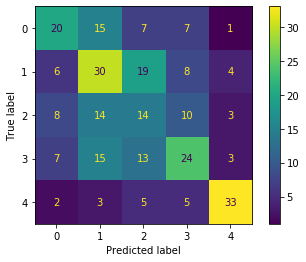

C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1270: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Precision : 43.841 %
Recall : 43.841 %
F1_score : 43.841 %
FOLD 6
--------------------------------
Starting epoch 1
Starting testing
Accuracy for fold 6: 39 %
--------------------------------
[ 1/20] train_loss: 4.33568 valid_loss: 1.45749
Validation loss decreased (inf --> 1.457490).  Saving model ...
Starting epoch 2
Starting testing
Accuracy for fold 6: 45 %
--------------------------------
[ 2/20] train_loss: 1.36289 valid_loss: 1.33442
Validation loss decreased (1.457490 --> 1.334421).  Saving model ...
Starting epoch 3
Starting testing
Accuracy for fold 6: 50 %
--------------------------------
[ 3/20] train_loss: 1.25577 valid_loss: 1.17650
Validation loss decreased (1.334421 --> 1.176495).  Saving model ...
Starting epoch 4
Starting testing
Accuracy for fold 6: 46 %
--------------------------------
[ 4/20] train_loss: 1.18717 valid_loss: 1.33280
EarlyStopping counter: 1 out of 4
Starting epoch 5
Starting testing
Accuracy for fold 6: 44 %
--------------------------------
[ 5/20] 

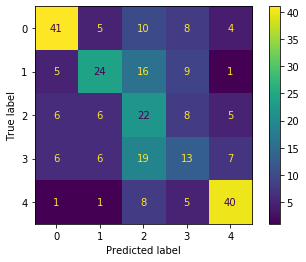

C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1270: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Precision : 50.725 %
Recall : 50.725 %
F1_score : 50.725 %
FOLD 7
--------------------------------
Starting epoch 1
Starting testing
Accuracy for fold 7: 44 %
--------------------------------
[ 1/20] train_loss: 4.76856 valid_loss: 1.42354
Validation loss decreased (inf --> 1.423541).  Saving model ...
Starting epoch 2
Starting testing
Accuracy for fold 7: 45 %
--------------------------------
[ 2/20] train_loss: 1.36777 valid_loss: 1.37651
Validation loss decreased (1.423541 --> 1.376510).  Saving model ...
Starting epoch 3
Starting testing
Accuracy for fold 7: 45 %
--------------------------------
[ 3/20] train_loss: 1.27963 valid_loss: 1.29554
Validation loss decreased (1.376510 --> 1.295541).  Saving model ...
Starting epoch 4
Starting testing
Accuracy for fold 7: 43 %
--------------------------------
[ 4/20] train_loss: 1.21329 valid_loss: 1.32586
EarlyStopping counter: 1 out of 4
Starting epoch 5
Starting testing
Accuracy for fold 7: 45 %
--------------------------------
[ 5/20] 

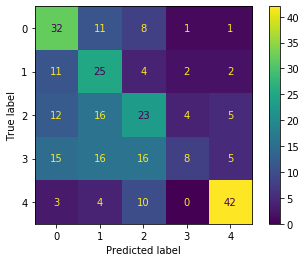

C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1270: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Precision : 47.101 %
Recall : 47.101 %
F1_score : 47.101 %
FOLD 8
--------------------------------
Starting epoch 1
Starting testing
Accuracy for fold 8: 33 %
--------------------------------
[ 1/20] train_loss: 4.40951 valid_loss: 1.57792
Validation loss decreased (inf --> 1.577921).  Saving model ...
Starting epoch 2
Starting testing
Accuracy for fold 8: 48 %
--------------------------------
[ 2/20] train_loss: 1.30326 valid_loss: 1.25806
Validation loss decreased (1.577921 --> 1.258062).  Saving model ...
Starting epoch 3
Starting testing
Accuracy for fold 8: 46 %
--------------------------------
[ 3/20] train_loss: 1.20111 valid_loss: 1.30631
EarlyStopping counter: 1 out of 4
Starting epoch 4
Starting testing
Accuracy for fold 8: 44 %
--------------------------------
[ 4/20] train_loss: 1.17372 valid_loss: 1.28721
EarlyStopping counter: 2 out of 4
Starting epoch 5
Starting testing
Accuracy for fold 8: 50 %
--------------------------------
[ 5/20] train_loss: 1.10273 valid_loss: 1.2

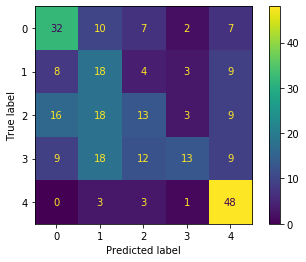

C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1270: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Precision : 45.091 %
Recall : 45.091 %
F1_score : 45.091 %
FOLD 9
--------------------------------
Starting epoch 1
Starting testing
Accuracy for fold 9: 40 %
--------------------------------
[ 1/20] train_loss: 4.55868 valid_loss: 1.38881
Validation loss decreased (inf --> 1.388808).  Saving model ...
Starting epoch 2
Starting testing
Accuracy for fold 9: 45 %
--------------------------------
[ 2/20] train_loss: 1.35669 valid_loss: 1.32951
Validation loss decreased (1.388808 --> 1.329508).  Saving model ...
Starting epoch 3
Starting testing
Accuracy for fold 9: 45 %
--------------------------------
[ 3/20] train_loss: 1.29026 valid_loss: 1.30575
Validation loss decreased (1.329508 --> 1.305748).  Saving model ...
Starting epoch 4
Starting testing
Accuracy for fold 9: 43 %
--------------------------------
[ 4/20] train_loss: 1.19168 valid_loss: 1.31363
EarlyStopping counter: 1 out of 4
Starting epoch 5
Starting testing
Accuracy for fold 9: 44 %
--------------------------------
[ 5/20] 

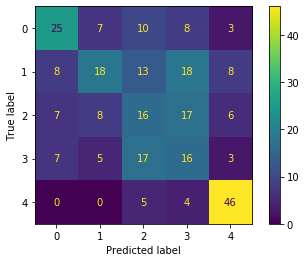

Precision : 44.000 %
Recall : 44.000 %
F1_score : 44.000 %
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 54.347826086956516 %
Fold 1: 51.08695652173913 %
Fold 2: 51.449275362318836 %
Fold 3: 55.434782608695656 %
Fold 4: 52.89855072463768 %
Fold 5: 48.91304347826087 %
Fold 6: 49.275362318840585 %
Fold 7: 53.2608695652174 %
Fold 8: 50.90909090909091 %
Fold 9: 51.272727272727266 %
Average: 51.884848484848476 %


C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1270: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [ ]:
# Define the K-fold Cross Validator

from sklearn.model_selection import KFold

torch.manual_seed(42)
k_folds = 10
num_epochs = 20
patience = 4
loss_function = nn.CrossEntropyLoss()
train_losses = []
valid_losses = []





DEVICE = torch.device("cpu")


  
  # For fold results
results = {}
kfold = KFold(n_splits=k_folds, shuffle=True)


# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(Dataset)):
    
    
# Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    valid_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      Dataset, 
                      batch_size=64, sampler=train_subsampler)
    validloader = torch.utils.data.DataLoader(
                      Dataset,
                      batch_size= 64, sampler=valid_subsampler)
    
    # Init the neural network
    network = CNN()
    
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
    
    # Run the training loop for defined number of epochs
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(1, num_epochs+1):

      # Print epoch
        print(f'Starting epoch {epoch}')

      # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader):
        
        # Get inputs
            inputs, targets = data
        
        # Zero the gradients
            optimizer.zero_grad()
        
        # Perform forward pass
            outputs = network(inputs)
        
        # Compute loss
            loss = loss_function(outputs, targets)
        
        # Perform backward pass
            loss.backward()
        
        # Perform optimization
            optimizer.step()
        
        # Print statistics
            train_losses.append(loss.item())
                
            
    # Process is complete.
        #print('Training process has finished. Saving trained model.')
        train_loss = np.average(train_losses)
        #print('train loss for this epoch : %.3f' % (train_loss))

    # Print about testing
        print('Starting testing')
    
    

    # Evaluationfor this fold
        correct, total = 0, 0
        with torch.no_grad():

      # Iterate over the test data and generate predictions
            for i, data in enumerate(validloader, 0):
        

        # Get inputs
                inputs, targets = data

        # Generate outputs
                outputs = network(inputs)

        # Set total and correct
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                
                loss = loss_function(outputs, targets)
                valid_losses.append(loss.item())

      # Print accuracy
            print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
            print('--------------------------------')
            results[fold] = 100.0 * (correct / total)
            valid_loss = np.average(valid_losses)
            #print('valid loss for this epoch : %.3f' % (valid_loss))
            epoch_len = len(str(num_epochs))
            print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
            print(print_msg)
            train_losses = []
            valid_losses = []
            early_stopping(valid_loss, network)
        
            if early_stopping.early_stop:
                print("Early stopping")
                break

    net = NeuralNetClassifier(
    CNN,
    max_epochs=6,
    lr=1e-3, #Learning rate
    batch_size=64,
    optimizer=optim.Adam, #Using adam optimizer
    criterion=nn.CrossEntropyLoss,
    device=DEVICE
    )
    
    
    
    

    X_train, X_test = X[train_ids], X[test_ids]
    y_train, y_test = y[train_ids], y[test_ids]

    net.fit(X_train, y_train)
    y_pred = net.predict(X_test)  #Obtaining the predictions
    #Obtaining labels of testset
    print("accuracy: ",accuracy_score(y_test, y_pred)) #accuracy
    plot_confusion_matrix(net, X_test, y_test.reshape(-1, 1)) #Confusion matrix
    plt.show()
    precision = sklearn.metrics.precision_score(y_test, y_pred, pos_label='positive', average='micro') #Precision
    print('Precision : %.3f %%' % (100.0 * precision))
    recall = sklearn.metrics.recall_score(y_test, y_pred, pos_label='positive', average='micro') #Recall
    print('Recall : %.3f %%' % (100.0 * recall))
    f1_score = sklearn.metrics.f1_score(y_test, y_pred, pos_label='positive', average='micro') #F1_score
    print('F1_score : %.3f %%' % (100.0 * f1_score))

    
  # Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
# Computing the average of the accuracy values
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

### Evaluation
Computing the accuracy of the trained model on the testset

In [ ]:
network.eval()
test_loss = []
with torch.no_grad():
    correct = 0
    total = 0

for images, labels in test_loader:
    outputs = network(images)
    _, predicted = torch.max(outputs.data, 1) #Computing the prediction of the model 
    total += labels.size(0)
    loss = criterion(output , target)
    test_loss.append(loss.item())

    correct += (predicted == labels).sum().item() #Computing the number of correct predicted items
print('Test Accuracy of the model on the {} test images: {} %'.format(len(testset),(correct / total) * 100))


Test Accuracy of the model on the 606 test images: 48.18481848184818 %


### Plotting the confusion matrix, accuracy, precision, recall and f1 score

y_train [0 1 2 ... 1 3 4]
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        2.4772       0.3443        1.5811  756.9939
accuracy:  0.3547854785478548


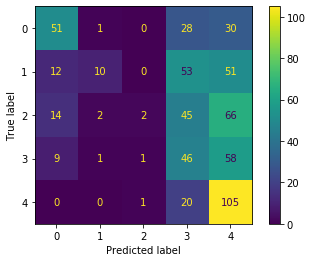

y_pred:  [3 4 4 3 3 4 4 0 3 4 4 4 4 4 4 4 3 4 4 4 4 3 4 4 3 3 4 0 4 3 3 0 0 4 4 3 3
 4 4 3 4 4 3 4 0 3 4 4 0 0 3 4 4 3 4 3 3 4 4 0 4 4 3 4 0 3 4 3 4 0 0 4 4 3
 3 4 4 4 3 4 3 0 4 3 4 3 4 4 3 3 4 3 4 3 4 4 4 4 3 3 3 0 3 3 4 3 4 3 4 3 3
 0 3 4 1 3 4 3 0 4 4 4 3 4 4 4 4 0 4 4 4 3 4 4 0 0 4 3 3 4 4 4 4 4 4 3 4 4
 4 4 0 4 4 3 4 4 0 3 4 4 4 3 4 0 0 3 4 4 1 4 4 4 3 4 4 4 4 3 3 4 3 4 4 3 3
 4 0 4 3 3 1 4 0 3 0 4 4 4 4 4 4 0 4 0 4 4 3 4 4 3 3 4 4 3 4 3 1 4 3 3 4 3
 4 3 3 3 3 0 4 3 3 4 4 0 4 4 3 3 3 3 3 0 4 3 4 3 4 4 4 0 4 3 0 4 4 4 4 3 4
 3 4 4 3 4 3 3 4 3 3 4 0 3 3 4 4 3 4 4 3 0 4 3 1 4 4 3 0 3 0 3 4 4 3 4 3 4
 3 3 3 4 3 4 4 4 0 4 4 0 4 0 4 0 3 3 4 4 4 3 3 4 0 1 4 3 0 3 4 4 1 0 3 0 4
 4 4 1 4 4 4 4 4 3 4 4 4 4 3 3 4 4 4 0 0 4 4 4 0 3 3 4 3 4 3 4 3 4 4 0 0 1
 4 4 4 3 4 0 2 4 4 4 4 3 3 3 4 4 3 4 4 4 3 4 0 4 3 3 4 3 4 3 4 4 4 4 3 1 4
 4 4 4 3 3 3 3 3 3 3 3 3 4 4 3 4 4 4 4 3 1 4 4 3 4 4 4 3 4 0 0 4 0 0 3 4 4
 3 4 1 0 4 4 4 0 4 3 3 4 4 4 0 3 4 4 3 4 4 4 4 4 3 4 4 3 3 4 0 4 3 4 4 4 3
 4 4 0 4 1 0 2 0

C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1270: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [ ]:
DEVICE = torch.device("cpu")
y_train = np.array([y for x, y in iter(trainset)])
print("y_train", y_train)
torch.manual_seed(0)
net = NeuralNetClassifier(
    CNN,
    max_epochs=1,
    lr=1e-3, #Learning rate
    batch_size=64,
    optimizer=optim.Adam, #Using adam optimizer
    criterion=nn.CrossEntropyLoss,
    device=DEVICE
)
net.fit(trainset, y=y_train)
y_pred = net.predict(testset)  #Obtaining the predictions
y_test = np.array([y for x, y in iter(testset)]) #Obtaining labels of testset
print("accuracy: ",accuracy_score(y_test, y_pred)) #accuracy
plot_confusion_matrix(net, testset, y_test.reshape(-1, 1)) #Confusion matrix
plt.show()

print("y_pred: ",y_pred)

precision = sklearn.metrics.precision_score(y_test, y_pred, pos_label='positive', average='micro') #Precision
print('Precision : %.3f %%' % (100.0 * precision))
recall = sklearn.metrics.recall_score(y_test, y_pred, pos_label='positive', average='micro') #Recall
print('Recall : %.3f %%' % (100.0 * recall))
f1_score = sklearn.metrics.f1_score(y_test, y_pred, pos_label='positive', average='micro') #F1_score
print('F1_score : %.3f %%' % (100.0 * f1_score))



